In [1]:
# float64
from jax import config
config.update('jax_enable_x64', True)

# simulate 8 devices (like a TPU-v3-8)
import os
flags = os.environ.get('XLA_FLAGS', '')
os.environ['XLA_FLAGS'] = flags + ' --xla_force_host_platform_device_count=8'

In [2]:
import os
os.chdir(os.path.expanduser('~/My Drive/msc-thesis/core'))

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [4]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import operator as op
from functools import partial
from jax import pmap, vmap, jit
from jax.tree_util import tree_map, tree_leaves, tree_reduce
from jax.flatten_util import ravel_pytree
from jax.lax import fori_loop
from jax.scipy import stats
from tqdm.auto import tqdm
import utils

In [5]:
n_dev = jax.local_device_count()
print(f'using {n_dev} devices')

using 8 devices


# HMC sampler

In [6]:
def ifelse(cond, val_true, val_false):
    return jax.lax.cond(cond, lambda x: x[0], lambda x: x[1], (val_true, val_false))

def leapfrog(params, momentum, log_prob_fn, step_size, n_steps):
    """Approximates Hamiltonian dynamics using the leapfrog algorithm."""

    # define a single step
    def step(i, args):
        params, momentum = args

        # update momentum
        grad = jax.grad(log_prob_fn)(params)
        momentum = tree_map(lambda m, g: m + 0.5 * step_size * g, momentum, grad)

        # update params
        params = tree_map(lambda p, m: p + m * step_size, params, momentum)

        # update momentum
        grad = jax.grad(log_prob_fn)(params)
        momentum = tree_map(lambda m, g: m + 0.5 * step_size * g, momentum, grad)

        return params, momentum

    # do 'n_steps'
    new_params, new_momentum = fori_loop(0, n_steps, step, (params, momentum))

    return new_params, new_momentum

def hmc_sample(key, params, log_prob_fn, n_steps, n_leapfrog_steps, step_size):
    """
    Runs HMC and returns the full Markov chain as a list.
    - params: array
    - log_prob_fn: function that takes params as the only argument and returns a scalar value
    """

    # define a single step
    @partial(pmap, in_axes=(None, 0))
    def step(i, args):
        params, chain, total_accept_prob, key = args
        key, normal_key, uniform_key = jax.random.split(key, 3)

        # generate random momentum
        momentum = utils.normal_like_tree(key, params)

        # leapfrog
        new_params, new_momentum = leapfrog(params, momentum, log_prob_fn, step_size, n_leapfrog_steps)

        # MH correction
        potentaial_energy_diff = log_prob_fn(new_params) - log_prob_fn(params)
        momentum_dot = tree_reduce(op.add, tree_map(lambda x: (x**2).sum(), tree_leaves(momentum)))
        new_momentum_dot = tree_reduce(op.add, tree_map(lambda x: (x**2).sum(), tree_leaves(new_momentum)))
        kinetic_energy_diff = 0.5*(momentum_dot - new_momentum_dot)
        log_accept_prob = potentaial_energy_diff + kinetic_energy_diff
        log_accept_prob = jnp.nan_to_num(log_accept_prob, nan=-jnp.inf)
        accept_prob = jnp.minimum(1, jnp.exp(log_accept_prob))
        total_accept_prob += accept_prob
        accept = jax.random.uniform(uniform_key) < accept_prob
        params = ifelse(accept, new_params, params)

        # store params
        chain = chain.at[i].set(ravel_pytree(params)[0])

        return params, chain, total_accept_prob, key

    # ravel params
    params_raveled, unravel_fn = ravel_pytree(params)
    n_params = len(params_raveled)
    chain = jnp.zeros([n_dev, n_steps, n_params])

    # replicate args across devices
    keys = jax.random.split(key, n_dev)
    params = pmap(lambda _: params)(jnp.arange(n_dev))
    total_accept_prob = jnp.zeros(n_dev)

    # do 'n_steps'
    pbar = tqdm(range(n_steps))
    for epoch in pbar:
        params, chain, total_accept_prob, keys = step(epoch, (params, chain, total_accept_prob, keys))
        avg_accept_prob = (total_accept_prob / (epoch+1)).mean()
        pbar.set_postfix_str(f'{avg_accept_prob=:6.2%}')

    # unravel chain
    chain = pmap(vmap(unravel_fn))(chain)

    return chain

# distributions

In [7]:
n_class = 10
alpha_prior = 0.03
y = 0
y_one_hot = jax.nn.one_hot(y, n_class)
alpha_post = alpha_prior + y_one_hot

def dirichlet_logpdf(log_probs, alpha):
    return ((alpha-1) * log_probs).sum()

def logits_logpdf(logits, alpha, corrected=False):
    log_probs = jax.nn.log_softmax(logits)
    K = len(log_probs)
    logsoftmax_correction = 0.5 * (jnp.log(K) + jax.scipy.special.logsumexp(2*log_probs))
    if corrected: return  dirichlet_logpdf(log_probs, alpha+1) # + logsoftmax_correction
    else: return dirichlet_logpdf(log_probs, alpha)

# test posterior functions
logits = jnp.zeros(n_class)
key = jax.random.PRNGKey(0)
log_probs = jax.nn.log_softmax(logits)
print(dirichlet_logpdf(log_probs, alpha_post))
print(logits_logpdf(logits, alpha_post, corrected=False))
print(logits_logpdf(logits, alpha_post, corrected=True))

20.032490309048196
20.032490309048196
-2.993360620892261


# sampling

In [8]:
logits = jnp.zeros(n_class)
key = jax.random.PRNGKey(0)
hmc_kwargs = dict(key=key, n_steps=1_000, n_leapfrog_steps=1_000)

In [9]:
%%time
# logits (raw)
log_prob_fn = partial(logits_logpdf, alpha=alpha_post, corrected=False)
chain = hmc_sample(params=logits, log_prob_fn=log_prob_fn, step_size=0.01, **hmc_kwargs)
logit_raw_probs = jax.nn.softmax(chain)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1.84 s, sys: 120 ms, total: 1.96 s
Wall time: 883 ms


In [10]:
%%time
# logits (corrected)
log_prob_fn = partial(logits_logpdf, alpha=alpha_post, corrected=True)
chain = hmc_sample(params=logits, log_prob_fn=log_prob_fn, step_size=0.5, **hmc_kwargs)
logit_corr_probs = jax.nn.softmax(chain)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1.92 s, sys: 110 ms, total: 2.03 s
Wall time: 817 ms


# plots

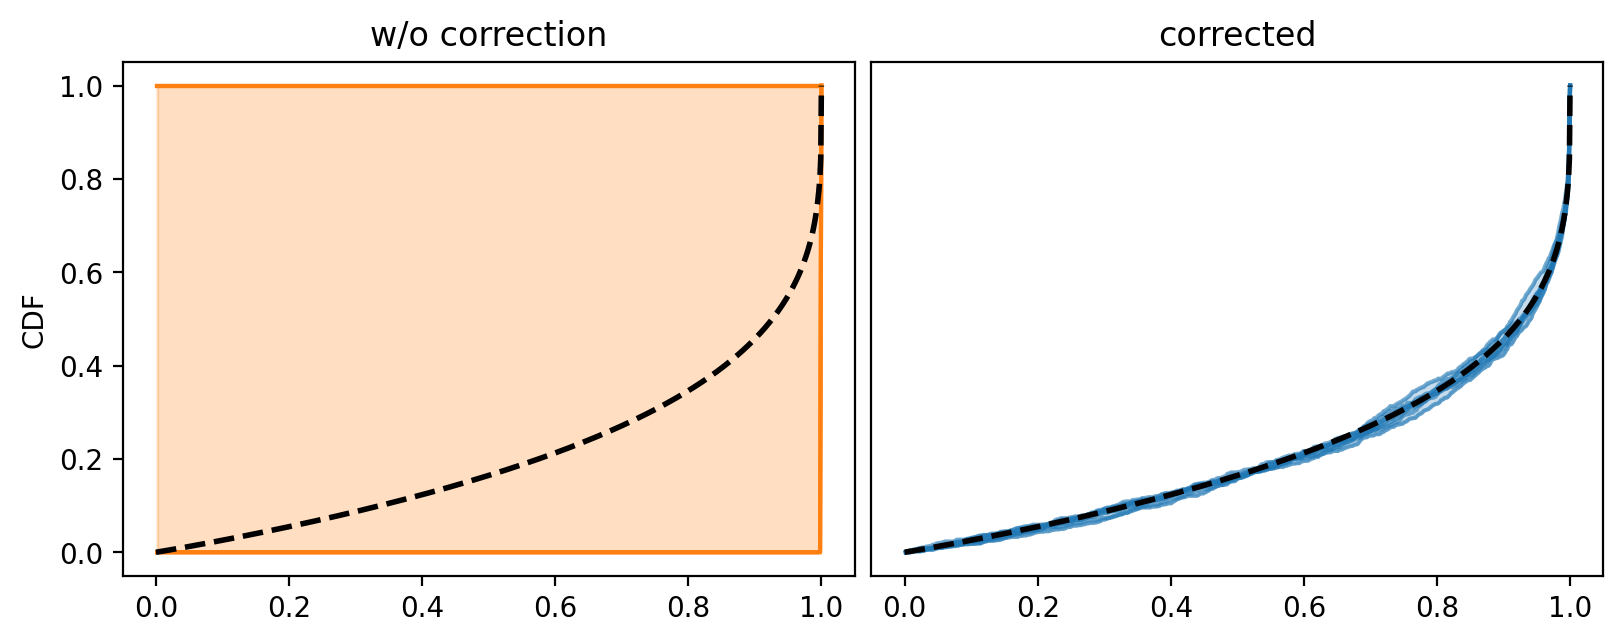

In [11]:
to_plot = {
    'w/o correction': logit_raw_probs,
    'corrected': logit_corr_probs,
}
fig, axs = plt.subplots(1, len(to_plot), figsize=(8, 3.1), layout='compressed')

# empirical marginals
for i, (name, probs) in enumerate(to_plot.items()):
    # color = f'C{i}'
    color = 'tab:orange' if i == 0 else 'tab:blue'
    bins = jnp.linspace(0, 1, 500)
    bincount = pmap(lambda p: jnp.histogram(p[:, 0], bins, density=False)[0])(probs)
    cdf = jnp.cumsum(bincount, -1) / probs.shape[1]

    # plot interval
    cdf_mean = cdf.mean(0)
    cdf_lo = cdf.min(0)
    cdf_hi = cdf.max(0)
    axs[i].fill_between(bins[1:], cdf_lo, cdf_hi, color=color, alpha=0.25)

    # plot each cdf sample
    for y in cdf:
        axs[i].plot(bins[1:], y, c=color, alpha=0.6)

    axs[i].set_title(name)
    axs[i].set_xticks(jnp.linspace(0, 1, 6))

# true marginal
x_ = jnp.linspace(0, 1, 1_000)
y_ = stats.beta.cdf(x_, alpha_post[0], alpha_post[1:].sum())
for ax in axs:
    ax.plot(x_, y_, ls='--', c='black', lw=2)

# disable repeated y axis
for ax in axs[1:]:
    ax.set(yticklabels=[])
    ax.tick_params(left=False)

axs[0].set_ylabel('CDF')
plt.savefig('../plots/dirichlet_sampling.pdf')
plt.show()